In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from mpl_toolkits.axes_grid1 import AxesGrid
from skimage.registration import phase_cross_correlation

In [2]:
#load of the 4D STEM dataset. 
folder = 'Z:/UCAS 4D-STEM/Roger/Figure 5/1/'
diff_data = np.load(folder+"data.npy")

Text(0.5, 1.0, 'averaged CBED')

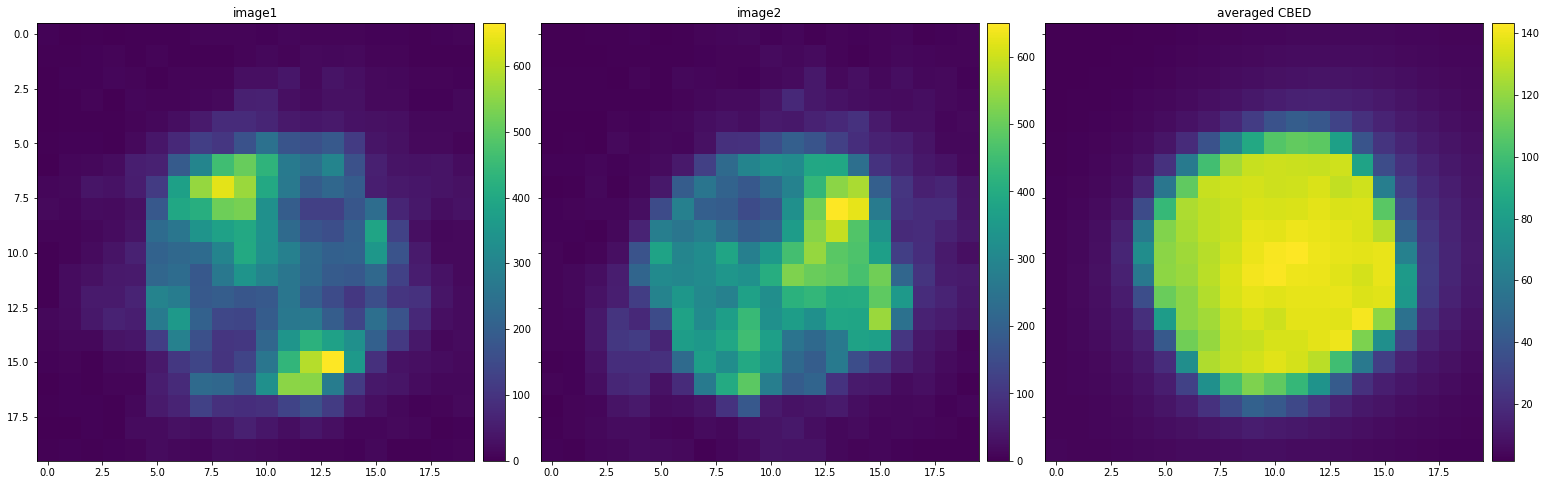

In [3]:
left= 118
right = 138
lower = 117
upper = 137
pacbed = np.average(diff_data, axis=(0,1))
fig =plt.figure(1, figsize=(90, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1, 3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(diff_data[0,1,lower:upper, left:right], cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("image1")
im=grid[1].imshow(diff_data[1,1,lower:upper, left:right], cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("image2")
im=grid[2].imshow(pacbed[lower:upper, left:right], cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("averaged CBED")

In [4]:
#Trim the CBED
trim_data = diff_data[:,:,lower:upper, left:right].copy()
pacbed = np.average(trim_data, axis=(0,1))
thresh = np.max(pacbed)*0.3
BFdisk = pacbed > thresh
mpacbed = pacbed * BFdisk

In [5]:
#detrermine the center of mass of CBEDs.
def GetiCoM(dat4d: np.ndarray):
    """Get Ronchigram Center of Mass Shifts from 4D Dataset

    :param dat4d: 4D Dataset, 2-spatial, 2-diffraction dimensions
    :param RCX: X Center of the Ronchigram (pixels)
    :param RCY: Y Center of the Ronchigram (pixels)
    :param RCal: Calibration of the Ronchigram (pixels/mrad)
    :param RI: Inner Radius for CoM Measurement (mrad)
    :param RO: Outer Radius for CoM Measurement (mrad)
    :return iCoM as ndarray
    """
    #get the integrated center of mass image along x and y direction.
    X, Y = np.meshgrid(np.arange(0, dat4d.shape[3]), np.arange(0, dat4d.shape[2]))
    #get the averaged intensity of each CBED pattern.
    avg = np.average(dat4d, axis=(2,3))
    return np.average(dat4d * X, axis=(2,3))/avg, np.average(dat4d * Y, axis=(2,3))/avg

In [6]:
CoMX,CoMY=GetiCoM(trim_data)
middlex = int(trim_data.shape[1]/2)
middley = int(trim_data.shape[0]/2)
CoMX -= CoMX[middley, middlex]
CoMY -= CoMY[middley, middlex]
#load the reference CoM value.
ref_folder = 'Z:/UCAS 4D-STEM/Roger/Figure 5/1/ref/'
rCoMX = np.load(ref_folder + "ref comx.npy")
rCoMY = np.load(ref_folder + "ref comy.npy")
rCoMX = CoMX - rCoMX
rCoMY = CoMY - rCoMY
#rCoMX = rCoMX - np.average(rCoMX)
#rCoMY = rCoMY - np.average(rCoMY)

Text(0.5, 1.0, 'amplitude')

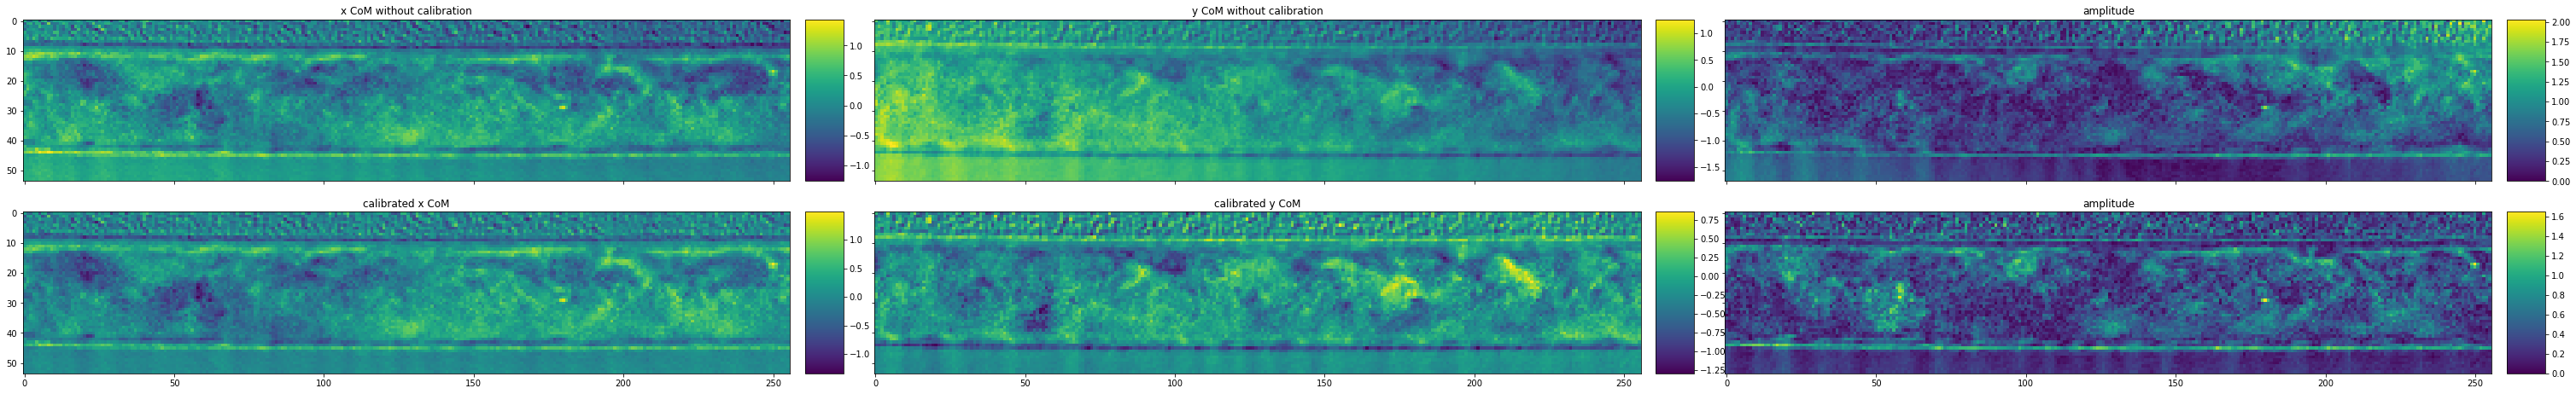

In [7]:
#compare the result with and without calibration
fig =plt.figure(1, figsize=(180, 120))
grid=AxesGrid(fig, 236, nrows_ncols=(2, 3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(CoMX, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("x CoM without calibration")
im=grid[1].imshow(CoMY, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("y CoM without calibration")
im=grid[2].imshow(np.sqrt(CoMY*CoMY+CoMX*CoMX), cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("amplitude")
im=grid[3].imshow(rCoMX, cmap=plt.cm.viridis)
grid.cbar_axes[3].colorbar(im)
grid[3].set_title("calibrated x CoM")
im=grid[4].imshow(rCoMY, cmap=plt.cm.viridis)
grid.cbar_axes[4].colorbar(im)
grid[4].set_title("calibrated y CoM")
im=grid[5].imshow(np.sqrt(rCoMY*rCoMY+rCoMX*rCoMX), cmap=plt.cm.viridis)
grid.cbar_axes[5].colorbar(im)
grid[5].set_title("amplitude")

Text(0.5, 1.0, 'image gradient')

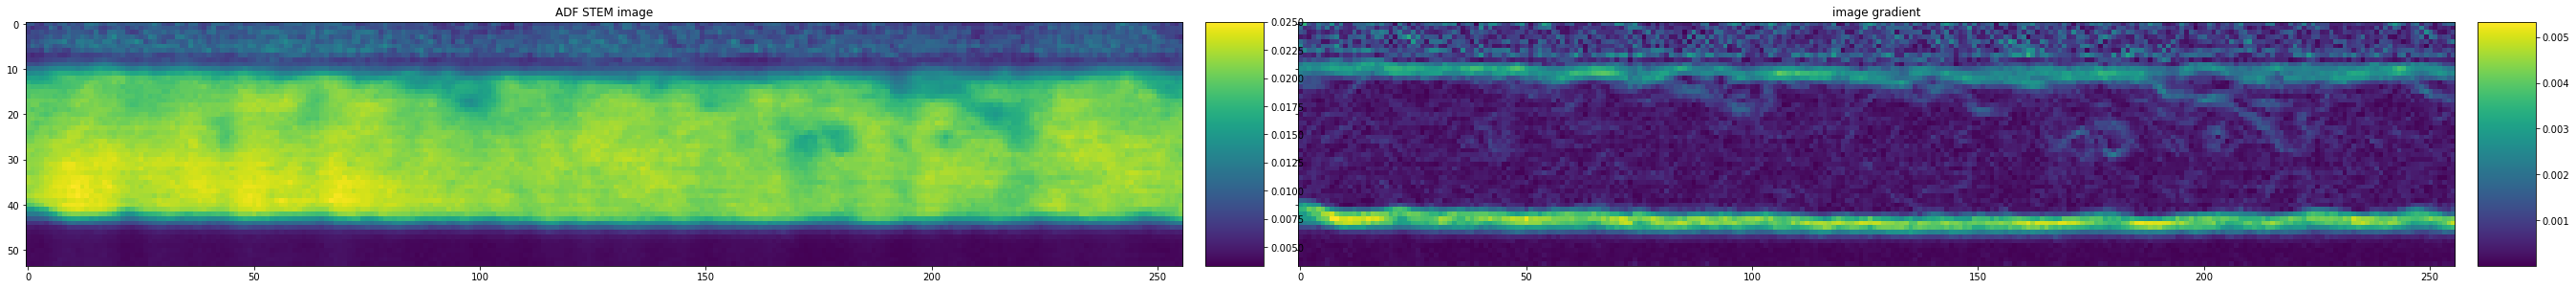

In [8]:
ADF = np.load(folder+'ADF.npy')
grady, gradx = np.gradient(ADF)
#show the ADF STEM image and its gradient.abs
fig =plt.figure(1, figsize=(160, 80))
grid=AxesGrid(fig, 236, nrows_ncols=(1, 2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(ADF, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("ADF STEM image")
im=grid[1].imshow(np.sqrt(gradx*gradx+grady*grady), cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("image gradient")

In [9]:
#print the electric field using direct calibration.
EX = -rCoMX
EY = -rCoMY
EXY,EXX=np.gradient(EX);EYY,EYX=np.gradient(EY)
JMatrix =[np.sum(EXX*EXX),np.sum(EYX*EYX), np.sum(EXY*EXY), np.sum(EYY*EYY)]
tan_val = 2*np.sum(EYY*EYX-EXX*EXY)/(JMatrix[1]+JMatrix[2]-JMatrix[0]-JMatrix[3])
angle_val = math.atan(tan_val)
print(angle_val/2)
print(angle_val*90/np.pi)
print(JMatrix)

0.5031197672774428
28.826639254601652
[261.664489671919, 252.02244430355114, 544.4674130566999, 380.4774031945467]


In [10]:
#rotate the electromagnetic field by 125.78 degree.
x_rot = -angle_val/2# + np.pi/2  #flip
y_rot = -angle_val/2# + np.pi/2
rEX = EX * np.cos(x_rot) - EY * np.sin(y_rot)
rEY = EX * np.sin(x_rot) + EY * np.cos(y_rot)

In [11]:
EField = rEX + 1j*rEY
EMag = np.abs(EField)
EAngle = np.angle(EField)
EMagNorm = EMag / np.amax(EMag)*1.5
EHSV = np.zeros(rCoMX.shape + (3,), dtype=float)
for i in range(rCoMX.shape[0]):
    for j in range(rCoMX.shape[1]):
        EHSV[i, j] = EAngle[i,j] / (2 * np.pi) % 1, 1, EMagNorm[i, j]
ERGB=hsv_to_rgb(EHSV)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Vector plot')

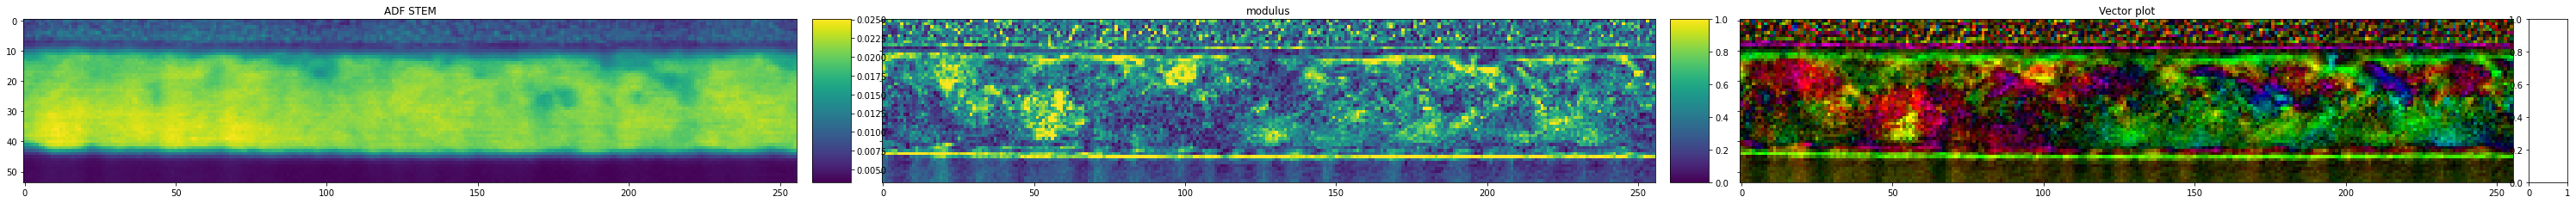

In [12]:
fig =plt.figure(1, figsize=(180, 60))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(ADF)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('ADF STEM')
im=grid[1].imshow(EMag, cmap=plt.cm.viridis, vmax = 1.0)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("modulus")
im=grid[2].imshow(ERGB)
grid[2].set_title("Vector plot")

In [13]:
#load the PACBED reference.
pacbed = np.load(ref_folder+"pacbed.npy")
ShiftX = np.zeros_like(CoMX)
ShiftY = np.zeros_like(CoMY)
for i in range(trim_data.shape[0]):
    for j in range(trim_data.shape[1]):
        shift, error, diffphase = phase_cross_correlation(pacbed, trim_data[i, j],  upsample_factor=100)
        ShiftX[i, j] = -shift[1]
        ShiftY[i, j] = -shift[0]

In [14]:
ShiftX -= ShiftX[middley, middlex]
ShiftY -= ShiftY[middley, middlex]
#load the reference CoM value.
rShiftX = np.load(ref_folder + "ref ccx.npy")
rShiftY = np.load(ref_folder + "ref ccy.npy")
rShiftX = ShiftX - rShiftX
rShiftY = ShiftY - rShiftY
#rShiftX = rShiftX - np.average(rShiftX)
#rShiftY = rShiftY - np.average(rShiftY)

Text(0.5, 1.0, 'calibrated amplitude')

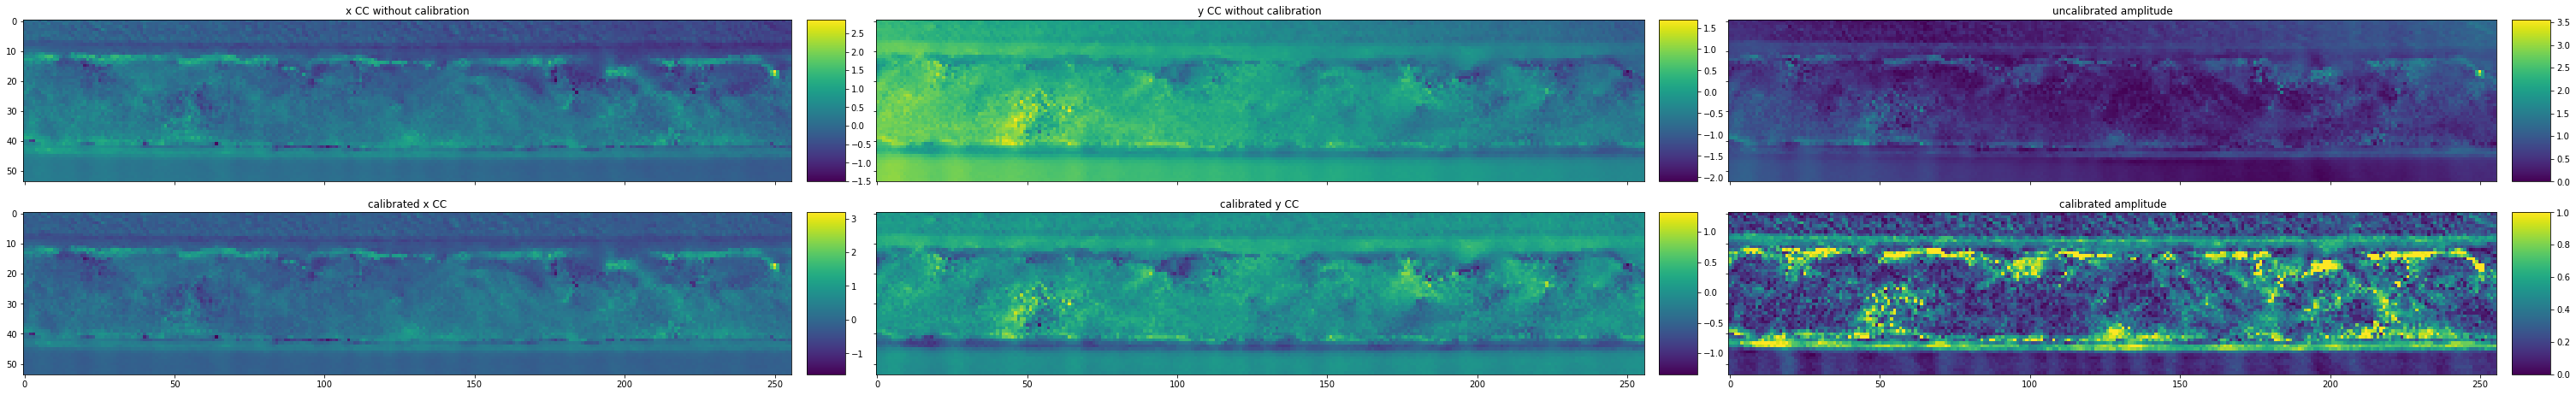

In [15]:
#direct average the frame.
fig =plt.figure(1, figsize=(180, 120))
grid=AxesGrid(fig, 236, nrows_ncols=(2, 3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(ShiftX, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("x CC without calibration")
im=grid[1].imshow(ShiftY, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("y CC without calibration")
im=grid[2].imshow(np.sqrt(ShiftX*ShiftX+ShiftY*ShiftY), cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("uncalibrated amplitude")
im=grid[3].imshow(rShiftX, cmap=plt.cm.viridis)
grid.cbar_axes[3].colorbar(im)
grid[3].set_title("calibrated x CC")
im=grid[4].imshow(rShiftY, cmap=plt.cm.viridis)
grid.cbar_axes[4].colorbar(im)
grid[4].set_title("calibrated y CC")
im=grid[5].imshow(np.sqrt(rShiftX*rShiftX+rShiftY*rShiftY), cmap=plt.cm.viridis, vmax = 1.0)
grid.cbar_axes[5].colorbar(im)
grid[5].set_title("calibrated amplitude")

In [16]:
#determine the rotation angle
EX = -rShiftX
EY = -rShiftY
EXY,EXX=np.gradient(EX);EYY,EYX=np.gradient(EY)
JMatrix =[np.sum(EXX*EXX),np.sum(EYX*EYX), np.sum(EXY*EXY), np.sum(EYY*EYY)]
tan_val = 2*np.sum(EYY*EYX-EXX*EXY)/(JMatrix[1]+JMatrix[2]-JMatrix[0]-JMatrix[3])
angle_val = math.atan(tan_val)
print(angle_val/2)
print(angle_val*90/np.pi)
print(JMatrix)

0.15224583165048539
8.72304360203206
[193.51, 110.13712500000001, 432.62422499999997, 232.0202]


In [17]:
#rotate the electromagnetic field by 125.78 degree.
x_rot = -angle_val/2# + np.pi/2  #flip
y_rot = -angle_val/2# + np.pi/2
rEX = EX * np.cos(x_rot) - EY * np.sin(y_rot)
rEY = EX * np.sin(x_rot) + EY * np.cos(y_rot)

In [18]:
#rCoMX = rCoMX - np.average(rCoMX)
#rCoMY = rCoMY - np.average(rCoMY)
EField = rEX + 1j*rEY
EMag = np.abs(EField)
EAngle = np.angle(EField)
EMagNorm = EMag / np.amax(EMag)*1.5
EHSV = np.zeros(rCoMX.shape + (3,), dtype=float)
for i in range(rCoMX.shape[0]):
    for j in range(rCoMX.shape[1]):
        EHSV[i, j] = EAngle[i,j] / (2 * np.pi) % 1, 1, EMagNorm[i, j]
ERGB=hsv_to_rgb(EHSV)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Vector plot')

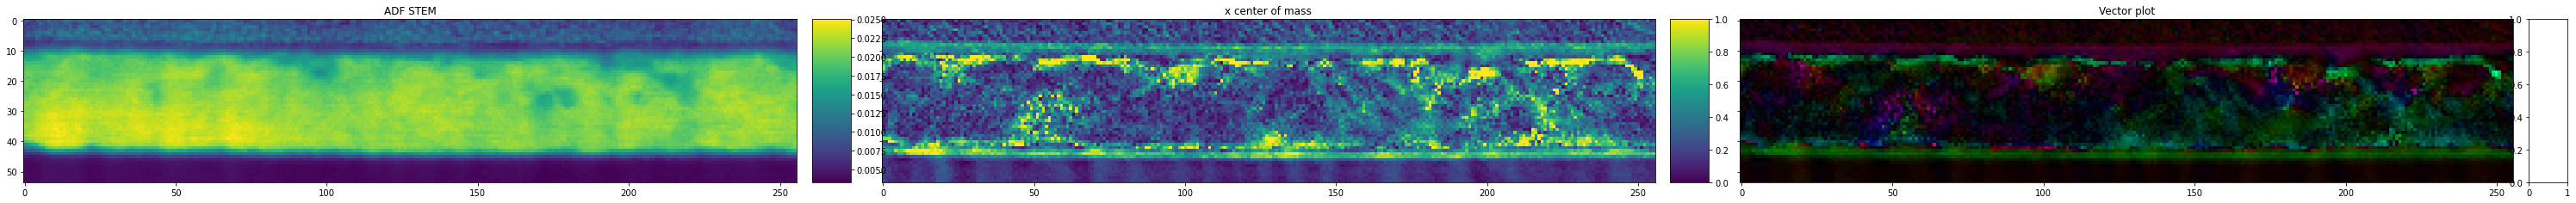

In [19]:
fig =plt.figure(1, figsize=(180, 60))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(ADF)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('ADF STEM')
im=grid[1].imshow(EMag, cmap=plt.cm.viridis, vmax = 1.0)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("x center of mass")
im=grid[2].imshow(ERGB)
grid[2].set_title("Vector plot")

In [20]:
#use different cross correlation method.
warp_mode = cv2.MOTION_TRANSLATION
# Specify the number of iterations.
number_of_iterations = 100;
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

In [21]:
CCX = np.zeros_like(ShiftX)
CCY = np.zeros_like(ShiftY)
for i in range(trim_data.shape[0]):
    for j in range(trim_data.shape[1]):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        warp_matrix[0,2] = -ShiftX[i, j]
        warp_matrix[1,2] = -ShiftY[i, j]
        warp_matrix = cv2.findTransformECC(trim_data[i, j], pacbed, warp_matrix, warp_mode, criteria, None, 1)
        CCX[i, j] = -warp_matrix[1][0,2]
        CCY[i, j] = -warp_matrix[1][1,2]

In [22]:
CCX -= CCX[middley, middlex]
CCY -= CCY[middley, middlex]
#load the reference CoM value.
rCCX = np.load(ref_folder + "ref ccx.npy")
rCCY = np.load(ref_folder + "ref ccy.npy")
rCCX = CCX - rCCX
rCCY = CCY - rCCY
#rShiftX = rShiftX - np.average(rShiftX)
#rShiftY = rShiftY - np.average(rShiftY)

Text(0.5, 1.0, 'amplitude')

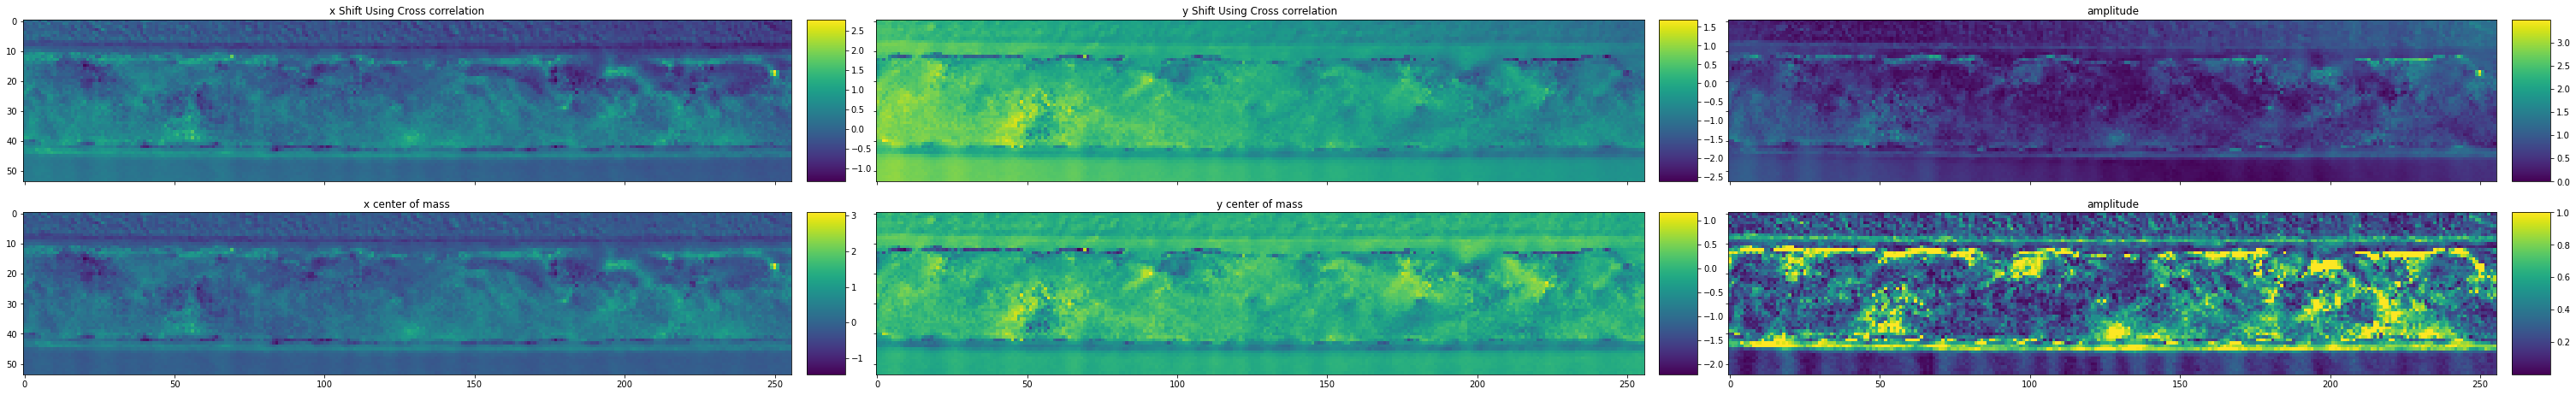

In [23]:
fig =plt.figure(1, figsize=(180, 120))
grid=AxesGrid(fig, 236, nrows_ncols=(2, 3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(CCX, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("x Shift Using Cross correlation")
im=grid[1].imshow(CCY, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("y Shift Using Cross correlation")
im=grid[2].imshow(np.sqrt(CCX*CCX+CCY*CCY), cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("amplitude")
im=grid[3].imshow(rCCX, cmap=plt.cm.viridis)
grid.cbar_axes[3].colorbar(im)
grid[3].set_title("x center of mass")
im=grid[4].imshow(rCCY, cmap=plt.cm.viridis)
grid.cbar_axes[4].colorbar(im)
grid[4].set_title("y center of mass")
im=grid[5].imshow(np.sqrt(rCCX*rCCX+rCCY*rCCY), cmap=plt.cm.viridis, vmax = 1.0)
grid.cbar_axes[5].colorbar(im)
grid[5].set_title("amplitude")

In [24]:
#determine the rotation angle
EX = -rCCX
EY = -rCCY
EXY,EXX=np.gradient(EX);EYY,EYX=np.gradient(EY)
JMatrix =[np.sum(EXX*EXX),np.sum(EYX*EYX), np.sum(EXY*EXY), np.sum(EYY*EYY)]
tan_val = 2*np.sum(EYY*EYX-EXX*EXY)/(JMatrix[1]+JMatrix[2]-JMatrix[0]-JMatrix[3])
angle_val = math.atan(tan_val)
print(angle_val/2)
print(angle_val*90/np.pi)
print(JMatrix)

0.5893482927125984
33.76716983567254
[230.55778619389523, 181.95526426858112, 483.0866181747718, 403.33586600331097]


In [28]:
#rotate the electromagnetic field by 125.78 degree.
x_rot = -angle_val/2 # np.pi/2  #flip
y_rot = -angle_val/2 # np.pi/2
rEX = EX * np.cos(x_rot) - EY * np.sin(y_rot)
rEY = EX * np.sin(x_rot) + EY * np.cos(y_rot)
#rCoMX = rCoMX - np.average(rCoMX)
#rCoMY = rCoMY - np.average(rCoMY)
EField = rEX + 1j*rEY
EMag = np.abs(EField)
EAngle = np.angle(EField)
EMagNorm = EMag / np.amax(EMag)*2.0
EHSV = np.zeros(rCoMX.shape + (3,), dtype=float)
for i in range(rCoMX.shape[0]):
    for j in range(rCoMX.shape[1]):
        EHSV[i, j] = EAngle[i,j] / (2 * np.pi) % 1, 1, EMagNorm[i, j]
ERGB=hsv_to_rgb(EHSV)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Vector plot')

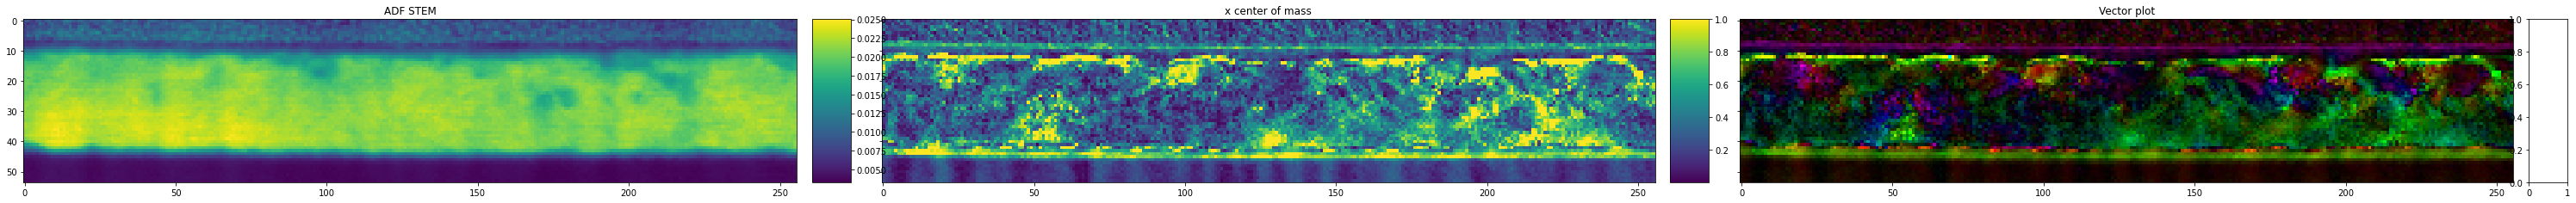

In [29]:
fig =plt.figure(1, figsize=(180, 60))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(ADF)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('ADF STEM')
im=grid[1].imshow(EMag, cmap=plt.cm.viridis, vmax = 1.0)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("x center of mass")
im=grid[2].imshow(ERGB)
grid[2].set_title("Vector plot")

Text(0.5, 1.0, 'Real CC')

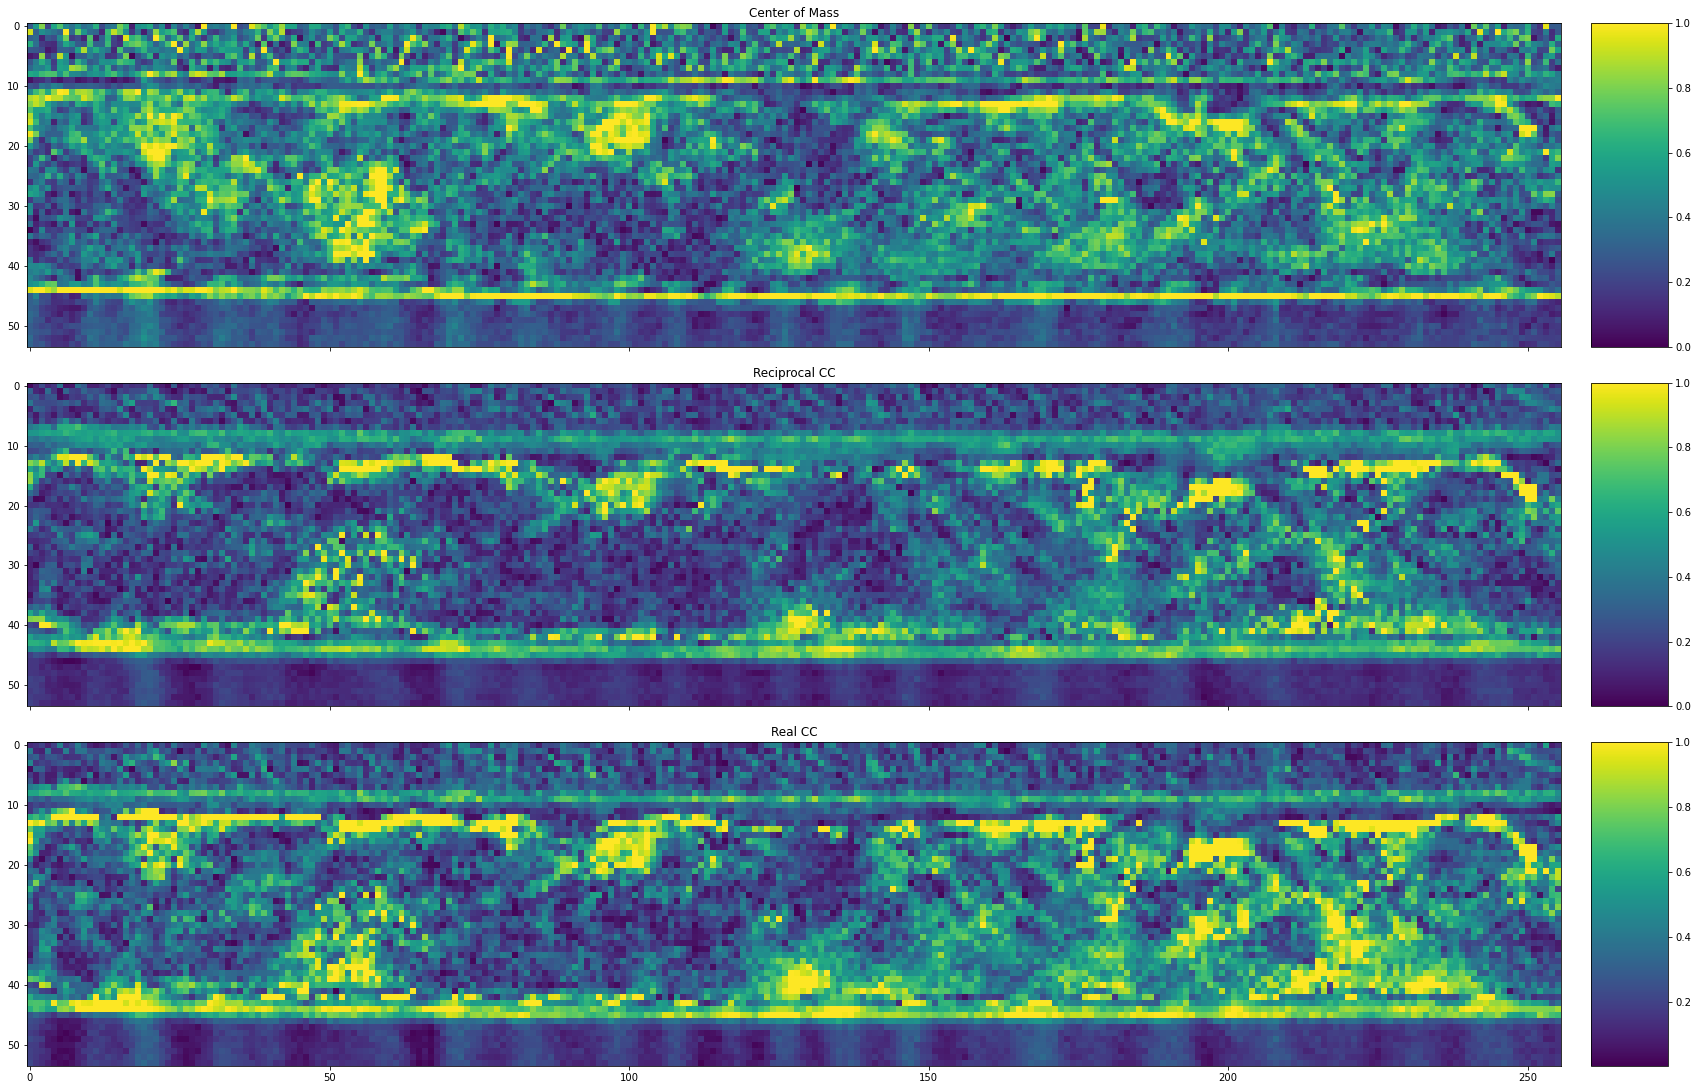

In [27]:
#make comparisons between the above results.
fig =plt.figure(1, figsize=(100, 100))
grid=AxesGrid(fig, 236, nrows_ncols=(3, 1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.sqrt(rCoMY*rCoMY+rCoMX*rCoMX), vmax= 1.0, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Center of Mass")
im=grid[1].imshow(np.sqrt(rShiftY*rShiftY+rShiftX*rShiftX), vmax= 1.0, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Reciprocal CC")
im=grid[2].imshow(np.sqrt(rCCX*rCCX+rCCY*rCCY), vmax= 1.0, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Real CC")